## Moisture Vapor Cyclone Model Training
In this notebook, we take the data that was downloaded from the GOES-16 satellite and associated with the IBTRaCS storm database as shown in the following gif:

<img src="aux/img/output.gif" width="800">

We now attempt to train a CNN on it using the paper "Tropical and Extratropical Cyclone Detection Using Deep Learning" (Kumler-Bonfanti et al). The paper uses a U-net architecture developed in "U-Net: Convolutional Networks for Biomedical Image Segmentation" (Ronneberger et al). The network architecture is shown below:

<img src="aux/img/unet_arch.png" width="800">

## Pre-processing Data
First, we need to pre-process our training data. Our raw input image size is `1500x1200px` with a healthy amount of white space around the actual area of interest. To account for this, we'll crop to a square image approximately around the full-disk extent then downsize to a more reasonable input image shape of `512x512px`. Additionally we'll do some background subtraction to isolate the mask. This will all be saved into a separate folder for training in keras/tf. Let's do this by defining some functions and work with a singular image for demonstration.

In [86]:
# input pillow package (import as PIL for backwards compatibility per https://stackoverflow.com/a/23834693)
from PIL import Image, ImageOps
import PIL
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import datetime as dt

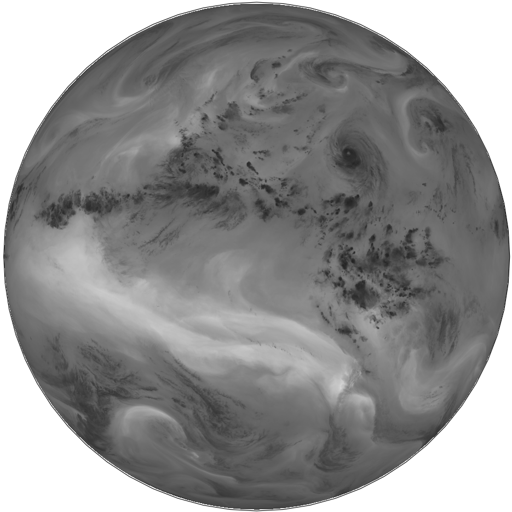

In [3]:
# define function to load/crop/resize GOES image data
def resize_crop_goes(fp, crop_dims = (300, 140, 1235, 1070), resize_dims = (512, 512), gray=True):
    # crop dims are empirically defined
    pic = Image.open(fp)
    if gray == True:
        pic = ImageOps.grayscale(pic)
    return pic.crop(crop_dims).resize(resize_dims)
    
fp = 'data/dataset/raw/2017-09-22-00-00-00_raw.png'
resize_crop_goes(fp)

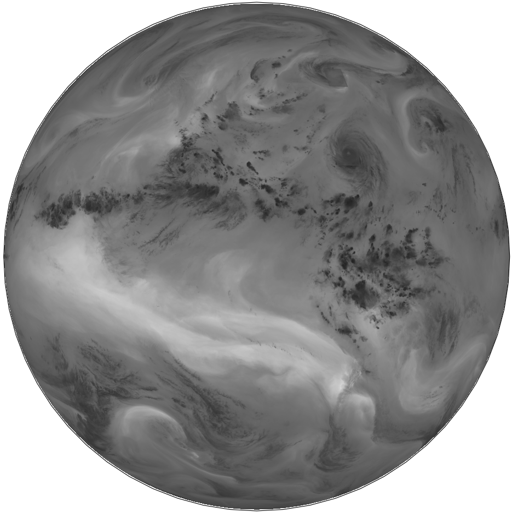

In [4]:
# next, lets look at the analog labeled image
# note that you can't really see the mask due to the grayscale but the computer can :)
fp_labeled = 'data/dataset/labeled/2017-09-22-00-00-00_labeled.png'
resize_crop_goes(fp_labeled)

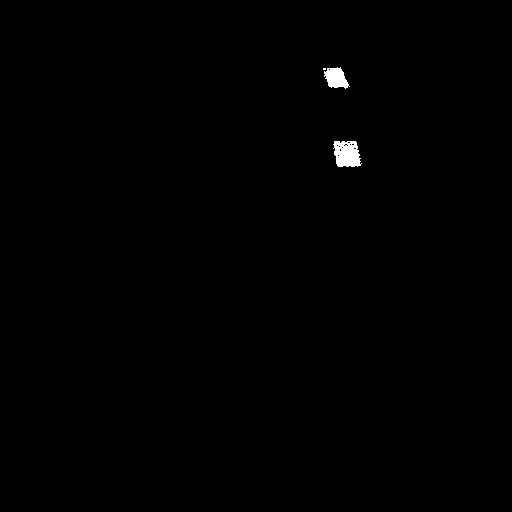

In [5]:
# finally, we can use background subtraction between the two images
def gen_mask(img1, img2):
    npimg1 = np.array(img1)
    npimg2 = np.array(img2)
    mask = np.abs(npimg1-npimg2)
    mask = np.where(mask>0, 1, 0).astype(np.bool_) # PIL needs dtype to infer, store as bool to play nice with labels in tf
    return Image.fromarray(mask)

masked_img = gen_mask(resize_crop_goes(fp), resize_crop_goes(fp_labeled))
masked_img

In [67]:
# now that we have our two functions, lets write into our `keras_dataset` folder with the baseline images and the truth images
# do some path stuff
read_path_raw = "data/dataset/raw"
write_path_raw =  "data/dataset/keras_dataset/raw"
read_path_labeled = "data/dataset/labeled"
write_path_mask = "data/dataset/keras_dataset/labels"
curr_dir = os.getcwd()

raw_files = os.listdir(os.path.join(curr_dir, read_path_raw))
labeled_files = os.listdir(os.path.join(curr_dir, read_path_labeled))

# get data pairs (raw/labeled) and do some image processing to convert to grayscale and get a binary mask as truth value
for data_pair in tqdm(list(zip(sorted(raw_files), sorted(labeled_files)))):
    img0 = resize_crop_goes(os.path.join(curr_dir, read_path_raw, data_pair[0]))  # raw image
    img1 = resize_crop_goes(os.path.join(curr_dir, read_path_labeled, data_pair[1]))  # labeled image
    img0.save(os.path.join(curr_dir, write_path_raw, data_pair[0]))
    mask = gen_mask(img0, img1)
    mask.save(os.path.join(os.getcwd(), write_path_mask, data_pair[1]))

## Assembling a dataset and training a model
Now that we have pre-processed data (`512x512px` grayscale raw images with binary mask truth output), we can assembly a keras dataset and train the model. This section is heavily adapted from a similar Keras tutorial (https://keras.io/examples/vision/oxford_pets_image_segmentation/). 

In [7]:
# define some global stuff (pretty lazily, I define image size in two places)
img_size = (512, 512)
num_classes = 2
batch_size = 32

# get paths to assemble training/truth data
input_img_paths = [os.path.join(write_path_raw, fname) for fname in sorted(raw_files)]
target_img_paths = [os.path.join(write_path_mask, fname) for fname in sorted(labeled_files)]
print("Number of samples:", len(input_img_paths))
for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 1460
data/dataset/keras_dataset/raw/2017-02-28-12-00-00_raw.png | data/dataset/keras_dataset/labels/2017-02-28-12-00-00_labeled.png
data/dataset/keras_dataset/raw/2017-03-01-00-00-00_raw.png | data/dataset/keras_dataset/labels/2017-03-01-00-00-00_labeled.png
data/dataset/keras_dataset/raw/2017-03-01-12-00-00_raw.png | data/dataset/keras_dataset/labels/2017-03-01-12-00-00_labeled.png
data/dataset/keras_dataset/raw/2017-03-02-00-00-00_raw.png | data/dataset/keras_dataset/labels/2017-03-02-00-00-00_labeled.png
data/dataset/keras_dataset/raw/2017-03-02-12-00-00_raw.png | data/dataset/keras_dataset/labels/2017-03-02-12-00-00_labeled.png
data/dataset/keras_dataset/raw/2017-03-03-00-00-00_raw.png | data/dataset/keras_dataset/labels/2017-03-03-00-00-00_labeled.png
data/dataset/keras_dataset/raw/2017-03-03-12-00-00_raw.png | data/dataset/keras_dataset/labels/2017-03-03-12-00-00_labeled.png
data/dataset/keras_dataset/raw/2017-03-04-00-00-00_raw.png | data/dataset/keras_dataset

In [8]:
# create a class that inherits from tf.keras.utils.Sequence (https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence)
# we can pass this directly into the model. Read the documentation for information on required methods

class GOES_Images(tf.keras.utils.Sequence):
    
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = tf.keras.preprocessing.image.load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="bool_")
        for j, path in enumerate(batch_target_img_paths):
            img = tf.keras.preprocessing.image.load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

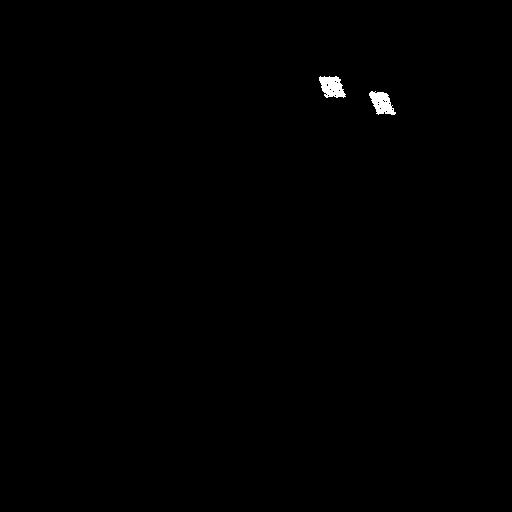

In [9]:
path = "data/dataset/keras_dataset/labels/2017-09-28-12-00-00_labeled.png"
img_size=(512, 512)
img = tf.keras.preprocessing.image.load_img(path, target_size=img_size, color_mode="grayscale")
img

In [10]:
# next define the U-net model
def get_model(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = tf.keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = GOES_Images(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = GOES_Images(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [12]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

In [52]:
# save model
model.save("cyclone_classifier_trained")

INFO:tensorflow:Assets written to: cyclone_classifier_trained/assets


In [97]:
# now that we've trained some weights, lets visualize the output
# lets look at the 2017 storm season including hurricane maria which is pretty interesting
# convert to date time, parse based on range criteria, sort
# bisect is the other option if you have a sorted list which os.listdir() does not return
start_date_str = dt.datetime.strptime("2017-09-01-12-00-00", "%Y-%m-%d-%H-%M-%S")
end_date_str = dt.datetime.strptime("2017-10-01-00-00-00", "%Y-%m-%d-%H-%M-%S")
vis_idx_list = []

input_dates = (dt.datetime.strptime(os.path.basename(date_string).split("_")[0], "%Y-%m-%d-%H-%M-%S") for date_string in input_fp_list)  # parenthesis in lieu of brackets for list comprehension  
date_range = filter(lambda x: start_date_str <= x <= end_date_str, input_dates)
string_dates = sorted(date.strftime("%Y-%m-%d-%H-%M-%S") for date in date_range)

maria_raw_fps = [os.path.join(write_path_raw, (fp+"_raw.png")) for fp in string_dates]
maria_labeled_fps = [os.path.join(write_path_mask, (fp+ "_labeled.png")) for fp in string_dates]

In [114]:
# now that we've got a list of dates of interest, lets visualize the output
val_gen = GOES_Images(batch_size, img_size, maria_raw_fps, maria_labeled_fps)
val_preds = model.predict(val_gen)

In [115]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)  # output is (512x512x2) softmax output/probabilities of classification. argmax() is way to force bool classification but tosses out probability info
    mask = np.expand_dims(mask, axis=-1) # argmax is (512x512), assuming image stuff likes (512x512x1)
    img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))
    return img

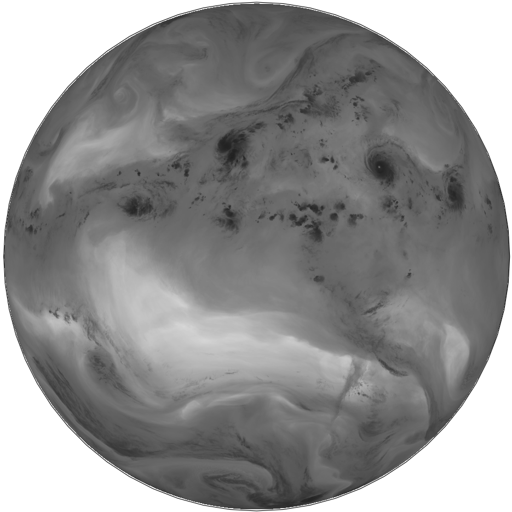

In [100]:
    
# Display results for validation image #10
i = 10

# Display input image
img = PIL.Image.open(maria_raw_fps[i])
display(img)

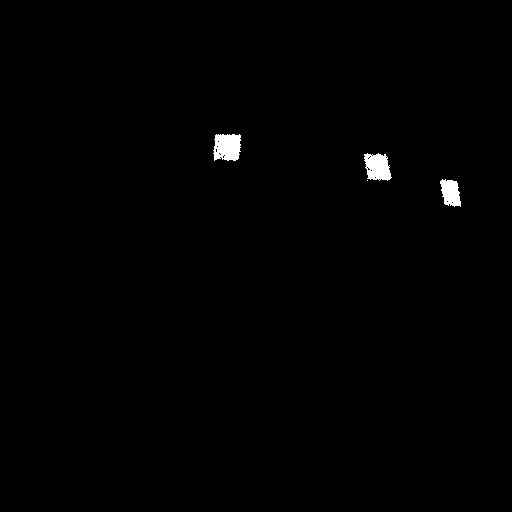

In [108]:
# Display ground-truth target mask
img = PIL.Image.open(maria_labeled_fps[i])
display(img)

In [111]:
fixed_mask = np.where(val_preds[10] <=0.1, 0, 1).astype(np.bool_)
img = Image.fromarray(fixed_mask)
display(img)